#Library installing and import

In [1]:
!pip install -q kaggle
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 7.0 MB/s eta 0:00:00


In [2]:
import os

import numpy as np
import librosa

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import keras_tuner

#Data Import from Kaggle

In [3]:
!touch kaggle.json

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 98% 1.19G/1.21G [00:12<00:00, 88.5MB/s]
100% 1.21G/1.21G [00:12<00:00, 105MB/s] 


In [6]:
!unzip gtzan-dataset-music-genre-classification.zip

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wa

#Data Import from file

Alternative data import

Load the file gtzan-dataset-music-genre-classification.zip in colab

In [ ]:
!unzip gtzan-dataset-music-genre-classification

#Tracks Loading

In [7]:
labels = os.listdir("/content/Data/genres_original/")

In [8]:
tracks = {}

for label in labels:
    tracks[label] = os.listdir("/content/Data/genres_original/" + label + "/")

tracks["jazz"].remove("jazz.00054.wav")     # removed because damaged

#Spectrograms creation

In [9]:
def create_spectrograms(tracks):
    """Given the dictionary of the track the function returns the dictionary of
    the spectrograms"""

    spectrograms = {}

    for label in labels:
        spectrograms[label] = []
        for track in tracks[label]:
            x, sr = librosa.load("/content/Data/genres_original/" + label + "/" + track)
            X = librosa.stft(x, n_fft=1024, hop_length=512)
            Xdb = librosa.amplitude_to_db(abs(X))
            spectrograms[label].append(Xdb)
    return spectrograms

In [10]:
spectrograms = create_spectrograms(tracks)

#Data augmentation

In [11]:
length_cut = 129

def cut(spectrogram):
    """Given a spectrogram the function returns a list of sub-spectrograms each
    with 50% overlap with the previous one"""

    cuts = []
    i = 0

    while(int(length_cut*i/2)+length_cut <= spectrogram.shape[1]):
        cuts.append(spectrogram[:, int(length_cut*i/2):int(length_cut*i/2)+length_cut])
        i += 1

    return cuts

def augment_data (spectrograms30):
    """Given a dictionary of spectrograms of 30s audiofiles the function returns
    the dictionary of 3s spectrograms obtained by splitting the original in 19
    overlapping sub-spectrograms each with 50% overlap with the previous one"""

    spectrograms3 = {}
    for label in labels:
        spectrograms3[label] = []
        for spec in spectrograms30[label]:
            spectrograms3[label].extend(cut(spec))
    return spectrograms3

In [12]:
def input_output_matrices(spect_dic):
    """The function converts the dictionary of spectrograms given in input in two
    tensors corresponding to the samples and corresponding target"""

    X = []
    Y = []

    for label in labels:
        for el in spect_dic[label]:
            X.append(el)
            Y.append(labels.index(label))

    return np.array(X), np.array(Y)

In [13]:
X, Y = input_output_matrices(augment_data(spectrograms))

#Train-Validation-Test splitting

In [15]:
!mkdir train
!mkdir val
!mkdir test

In [16]:
test_size = 0.3
val_size = 0.1

n_test = int(test_size * X.shape[0])
n_val = int(val_size * X.shape[0])
n_train = X.shape[0] - n_test - n_val

indexes = np.arange(X.shape[0])
np.random.shuffle(indexes)

Y_train=list()
Y_val=list()
Y_test=list()

""" we store to the disk the tensors corresponding to the samples, splitted in train, validation and test"""

for i in range(n_train):
  np.save("/content/train/X_"+str(i).zfill(6), X[indexes[i]])
  Y_train.append(Y[indexes[i]])

for i in range(n_val):
  np.save("/content/val/X_"+str(i).zfill(6), X[indexes[n_train+i]])
  Y_val.append(Y[indexes[n_train+i]])

for i in range(n_test):
  np.save("/content/test/X_"+str(i).zfill(6), X[indexes[n_train+n_val+i]])
  Y_test.append(Y[indexes[n_train+n_val+i]])

In [17]:
def saveFileNames(dir_path):
  """The function returns a list of the names of the files in the directory given in input"""

  names = list()
  for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
      names.append(path)
  return names

In [18]:
file_names_train = saveFileNames("train")
file_names_val = saveFileNames("val")
file_names_test = saveFileNames("test")

#Generators' creation

In [19]:
class Data_Generator(keras.utils.Sequence) :
  """Implementation of a Keras data generator that loads and provides batches
  of samples during the training/testing process"""

  def __init__(self, file_names, dataset, labels, batch_size,shuffle=True) :
    self.file_names = file_names
    self.dataset = dataset
    self.labels = labels
    self.batch_size = batch_size
    self.shuffle=shuffle
    self.on_epoch_end()


  def __len__(self) :
    return (np.ceil(len(self.file_names) / float(self.batch_size))).astype(int)


  def __getitem__(self, idx) :
      batch_indexes = self.indexes[idx*self.batch_size: (idx+1)*self.batch_size]
      batch_x = [self.file_names[i] for i in batch_indexes]

      batch_y=list()
      for el in batch_x:
        index = int(el[2:-4])
        batch_y.append(self.labels[index])

      if self.dataset=="train":
        return np.array([np.load("/content/train/"+str(file_name))
               for file_name in batch_x]), np.array(batch_y)
      elif self.dataset=="val":
        return np.array([np.load("/content/val/"+str(file_name))
               for file_name in batch_x]), np.array(batch_y)
      elif self.dataset=="test":
        return np.array([np.load("/content/test/"+str(file_name))
          for file_name in batch_x]), np.array(batch_y)

  def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.file_names))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [20]:
train_generator = Data_Generator(file_names_train,"train", Y_train, batch_size=64)
val_generator= Data_Generator(file_names_val, "val",Y_val, batch_size=64)
test_generator = Data_Generator(file_names_test, "test", Y_test, batch_size=64)

#Model

##Squeeze&Excite

In [21]:
class SqueezeAndExcite(keras.layers.Layer):
    """Implementation in Keras of the Squeeze&Excite block"""

    def __init__(
          self,
          filters,
          ratio=31.43,
          squeeze_activation="relu",
          excite_activation="sigmoid",
      ):
          super().__init__()

          self.filters = filters
          self.ratio = ratio
          self.squeeze_activation = squeeze_activation
          self.excite_activation = excite_activation
          self.bottleneck_filters = int(self.filters / self.ratio)

          self.global_average_pool = keras.layers.GlobalAveragePooling2D(keepdims=True)
          self.squeeze_dense = keras.layers.Dense(
              self.bottleneck_filters,
              activation=self.squeeze_activation,
          )
          self.excite_dense = keras.layers.Dense(
              self.filters, activation=self.excite_activation
          )

    def call(self, inputs):
        x = self.global_average_pool(inputs)
        x = self.squeeze_dense(x)
        x = self.excite_dense(x)
        x = tf.math.multiply(x, inputs)
        return x

##Model definition

In [22]:
def build_model(channels_params, ratio):
  """The function returns a Keras CNN model with the given parameters"""

  model = keras.Sequential()
  input_shape=(513,129,1)


  model.add(keras.layers.Conv2D(filters=channels_params[0], kernel_size=(3,3),strides=(1,1),padding="same",input_shape=input_shape))
  model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'))
  model.add(keras.layers.Dropout(0.25))
  model.add(SqueezeAndExcite(filters=channels_params[0],ratio=ratio))

  model.add(keras.layers.Conv2D(filters=channels_params[1],kernel_size=(3,3), strides=(1,1),padding="same"))
  model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'))
  model.add(keras.layers.Dropout(0.25))
  model.add(SqueezeAndExcite(filters=channels_params[1],ratio=ratio))


  model.add(keras.layers.Conv2D(filters=channels_params[2],kernel_size=(3,3), strides=(1,1),padding="same"))
  model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'))
  model.add(keras.layers.Dropout(0.25))
  model.add(SqueezeAndExcite(filters=channels_params[2],ratio=ratio))


  model.add(keras.layers.Conv2D(filters= channels_params[3],kernel_size=(3,3), strides=(1,1),padding="same"))
  model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'))
  model.add(keras.layers.Dropout(0.25))
  model.add(SqueezeAndExcite(filters=channels_params[3],ratio=ratio))


  model.add(keras.layers.Conv2D(filters=channels_params[4],kernel_size=(3,3), strides=(1,1),padding="same"))
  model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'))
  model.add(keras.layers.Dropout(0.25))
  model.add(SqueezeAndExcite(filters=channels_params[4],ratio=ratio))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(10, activation="softmax"))

  model.summary()

  return model

In [23]:
parameters_configurations = [[16, 32, 64, 128, 64],
                             [32, 64, 128, 256, 128],
                             [64, 128, 256, 512, 256],
                             [128, 256, 512, 1024, 512]]

ratio = 16

###Training

In [24]:
model = build_model(parameters_configurations[1], ratio)

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer='Adam', metrics=['accuracy'])

history=model.fit(train_generator,
                   epochs = 50,
                   validation_data = val_generator)

test_loss, test_acc = model.evaluate(test_generator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 513, 129, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 64, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 256, 64, 32)       0         
                                                                 
 squeeze_and_excite (Squeeze  (None, 256, 64, 32)      162       
 AndExcite)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 64, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 32, 64)      0

###Plot of results

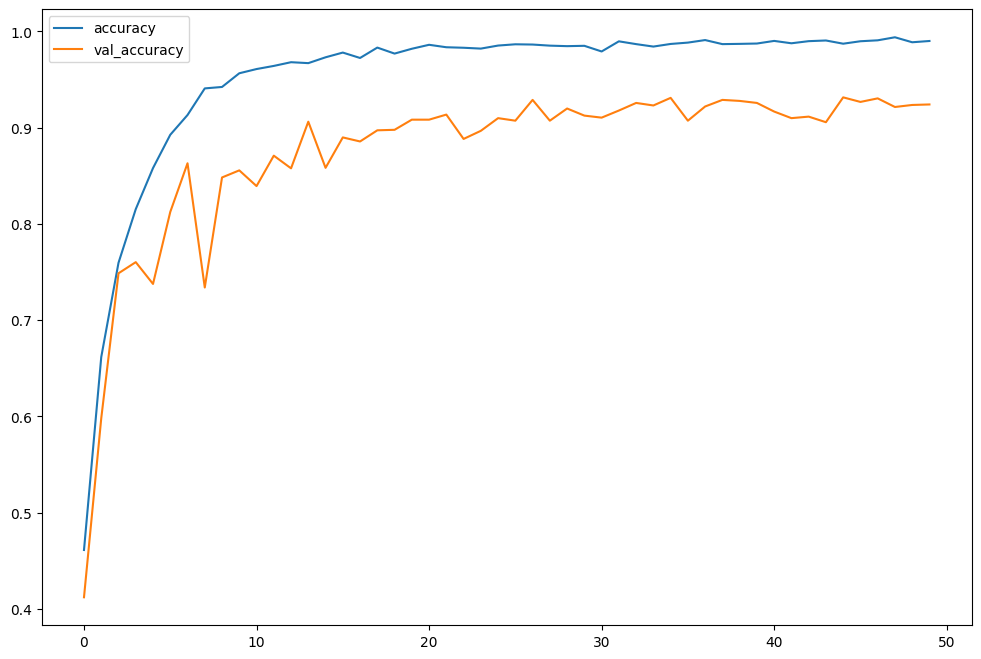

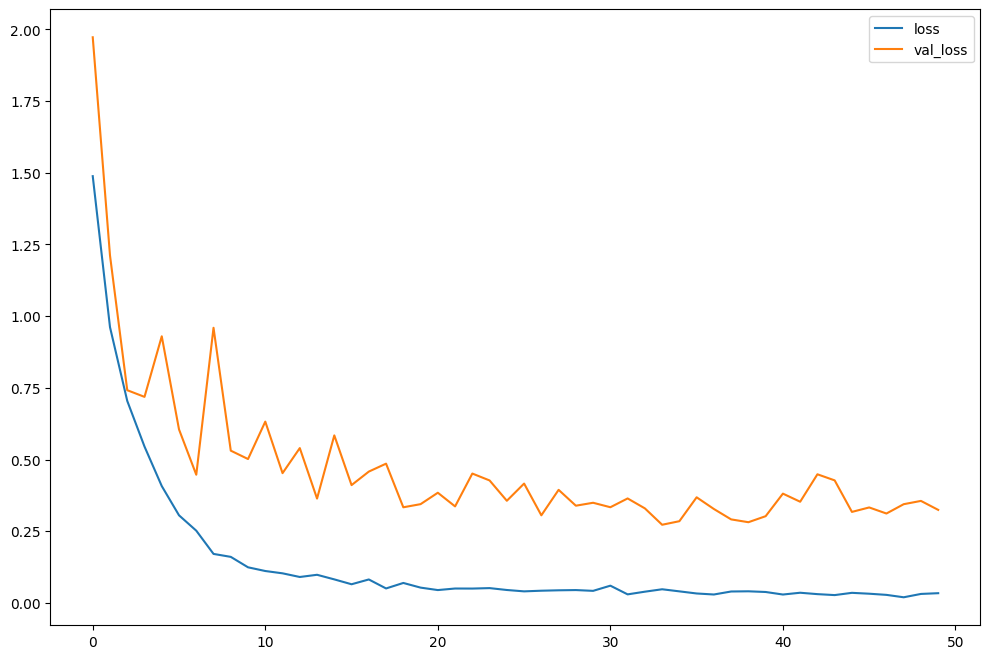


Test accuracy: 0.9304531216621399


In [25]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

print('')

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

print('\nTest accuracy:', test_acc)


##Model with Bayesian Optimisation

In [26]:
channels_params = [32, 64, 128, 256, 128]

def build_model_for_BO(hp):
    """The function creates, compiles and returns a model for the Bayesian Optimisation process"""

    model = keras.Sequential()
    input_shape=(513,129,1)

    ratio = hp.Float("ratio", min_value=8, max_value=32)


    model.add(keras.layers.Conv2D(filters=channels_params[0], kernel_size=(3,3),strides=(1,1),padding="same",input_shape=input_shape))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'))
    model.add(keras.layers.Dropout(0.25))
    model.add(SqueezeAndExcite(filters=channels_params[0],ratio=ratio))

    model.add(keras.layers.Conv2D(filters=channels_params[1],kernel_size=(3,3), strides=(1,1),padding="same"))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'))
    model.add(keras.layers.Dropout(0.25))
    model.add(SqueezeAndExcite(filters=channels_params[1],ratio=ratio))


    model.add(keras.layers.Conv2D(filters=channels_params[2],kernel_size=(3,3), strides=(1,1),padding="same"))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'))
    model.add(keras.layers.Dropout(0.25))
    model.add(SqueezeAndExcite(filters=channels_params[2],ratio=ratio))


    model.add(keras.layers.Conv2D(filters=channels_params[3],kernel_size=(3,3), strides=(1,1),padding="same"))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'))
    model.add(keras.layers.Dropout(0.25))
    model.add(SqueezeAndExcite(filters=channels_params[3],ratio=ratio))


    model.add(keras.layers.Conv2D(filters=channels_params[4],kernel_size=(3,3), strides=(1,1),padding="same"))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'))
    model.add(keras.layers.Dropout(0.25))
    model.add(SqueezeAndExcite(filters=channels_params[4],ratio=31.43))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer='Adam', metrics=['accuracy'])

    return model

###Training and Optimisation

In [27]:
tuner = keras_tuner.tuners.BayesianOptimization(
    build_model_for_BO,
    objective='val_accuracy',
    max_trials=3
)

tuner.search(train_generator, epochs=10, validation_data=val_generator)

Trial 3 Complete [00h 11m 24s]
val_accuracy: 0.8593255877494812

Best val_accuracy So Far: 0.8825079202651978
Total elapsed time: 00h 34m 07s


###Results

In [28]:
best_model = tuner.get_best_models(1)[0]

test_loss, test_acc = best_model.evaluate(test_generator)
test_acc

89/89 [==============================] - 28s 306ms/step - loss: 0.3804 - accuracy: 0.8753


0.8753073215484619

In [29]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

best_hyperparameters.get("ratio")

10.106981622665616